In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
import matplotlib.colors as mcolors
plt.rcParams["figure.figsize"] = (10,10)
numero = 1
# Medio Ambiente
# Social Externo
# Social Interno
# Gobierno Corporativo
path_area = "soce"
area = 'Social Externo'
path = './RNN/Salida/Flujo{num}/{area}/'.format(area = path_area.upper(),num = numero)

def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)

def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

df = pd.read_csv('./Data/Flujo{num}.csv'.format(num=numero), sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1
df = df[df.Area == area]
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)
df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)
# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_completo, y_completo, test_size=0.2, random_state=42)
model = tf.keras.models.load_model(path+'model_{}.h5'.format(path_area))
predictions = model.predict_classes(tf.convert_to_tensor(list(X_test)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


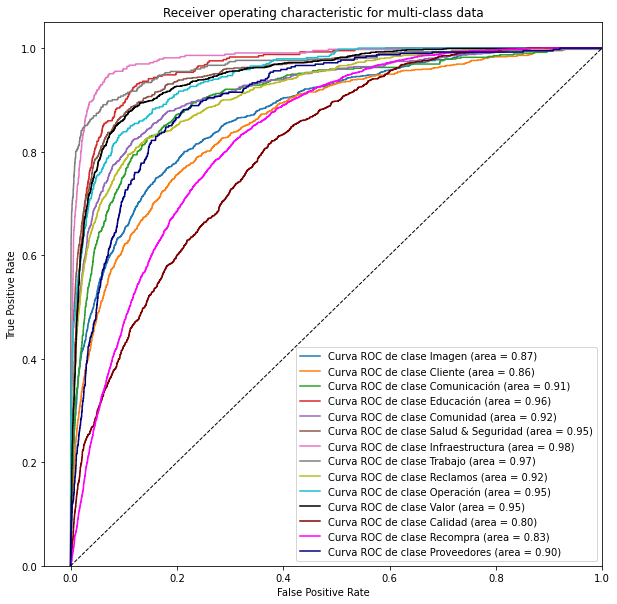

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=range(num_classes))
y_predic_bin = model.predict(tf.convert_to_tensor(list(X_test)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_predic_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
dict_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['#000000','#800000', '#FF00FF','#000080', '#00FFFF']
colors = cycle(dict_colors)
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='Curva ROC de clase {0} (area = {1:0.2f})'
             ''.format(list_dimensions[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
#plt.savefig("../Imagenes/SOCE/ROC_SOCE_2.png")
#plt.savefig(path+"roc.png")

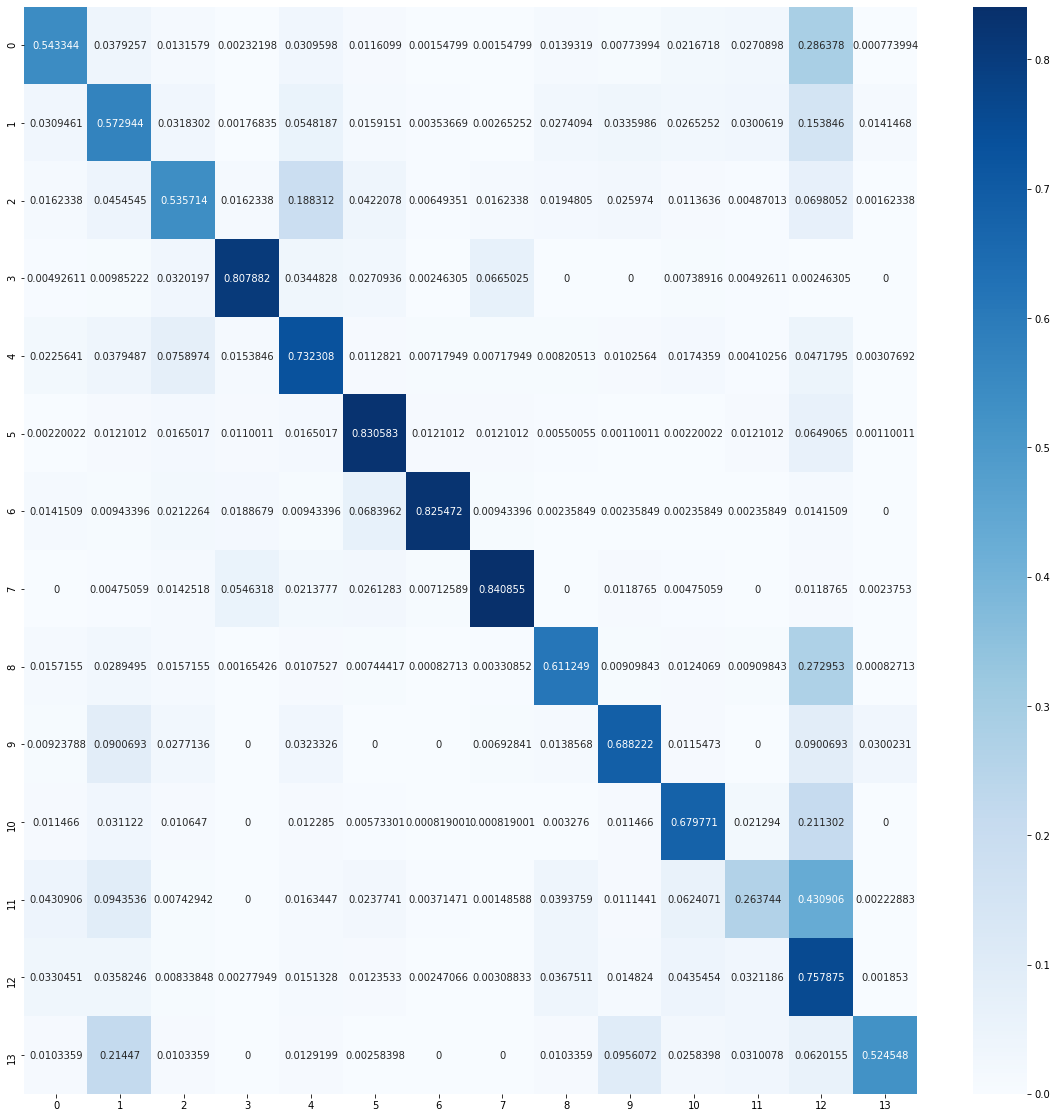

In [36]:
import seaborn as sn
matrix = confusion_matrix(y_test, predictions, normalize='true')
plt.figure(figsize=(20,20))
sn.heatmap(matrix, annot=True, cmap=plt.cm.Blues, fmt='g')
#plt.savefig(path+"confm.png")
plt.show()